# Project 2: Predicting Obesity Level 
By: Nathan To

## 1) Introduction (Problem)

I’m using machine learning to see if we can predict a person’s weight category (underweight, normal, overweight, or obese) just from basic lifestyle and body information such as age, weight, height, and eating habits. This is a classification problem. the model tries to put each person into one of several groups.

This kind of prediction is useful because it can give people or organizations a quick glimpse of someone’s health risk without needing a full medical check up. Knowing how different habits and traits are connected to weight status can also help raise awareness, guide lifestyle choices, and support public health programs.

Key question:
Given simple lifestyle and body stats, can we accurately predict someone’s obesity level?

## 2) Data (Source, Features, Target)

**File**: ObesityDataSet_raw_and_data_sinthetic.csv, each row is one person.

**What’s inside**: Things like gender, age, height, weight, family history, eating habits, physical activity (FAF), screen time (TUE), and transport (MTRANS).

**Target column**: This is the obesity level (the class we’re predicting). In some files it’s named NObeyesdad, in others NObesity. I’m using NObeyesdad here.

**Source**: Kaggle “Obesity Level” dataset.

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [2]:
# Make sure the file is in the same folder as your notebook
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
print(df.shape)
df.head()


(2111, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## 3) Pre-processing (What & Why)

- Turn text columns into numbers so the model can read them (label encoding).

- Keeps it simple — no heavy scaling or complicated settings.

- Choose the target column and split the data into training (80%) and testing (20%).

In [10]:
# --- Change this to "NObesity" if your file uses that name ---
TARGET = "NObeyesdad"


# Copy and simple label-encode ALL object (string) columns (quick and easy)
df_enc = df.copy()
labelers = {}

for col in df_enc.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))
    labelers[col] = le

# Features and target
X = df_enc.drop(columns=[TARGET])
y = df_enc[TARGET]

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_tr.shape, X_te.shape

((1688, 16), (423, 16))

## 4) Data Understanding / Visualization

I’ll make a few small charts:

- How many people are in each obesity level.

- The average Age for each group.

- The average Weight (or FAF = physical activity) for each group.

These quick charts help me spot simple patterns before building the model.

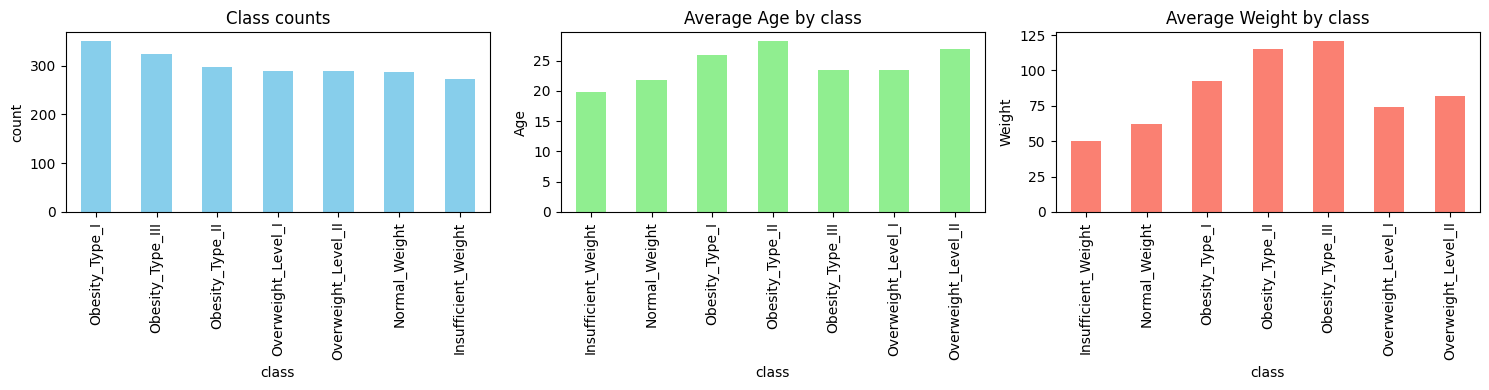

In [6]:
import matplotlib.pyplot as plt

target_name = TARGET

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Class counts
df[target_name].value_counts().plot(kind="bar", ax=axes[0], color='skyblue')
axes[0].set_title("Class counts")
axes[0].set_xlabel("class"); axes[0].set_ylabel("count")

# 2. Average Age by class (only if column exists)
if "Age" in df.columns:
    df.groupby(target_name)["Age"].mean().plot(kind="bar", ax=axes[1], color='lightgreen')
    axes[1].set_title("Average Age by class")
    axes[1].set_xlabel("class"); axes[1].set_ylabel("Age")

# 3. Average Weight by class (or FAF)
if "Weight" in df.columns:
    df.groupby(target_name)["Weight"].mean().plot(kind="bar", ax=axes[2], color='salmon')
    axes[2].set_title("Average Weight by class")
    axes[2].set_xlabel("class"); axes[2].set_ylabel("Weight")
elif "FAF" in df.columns:
    df.groupby(target_name)["FAF"].mean().plot(kind="bar", ax=axes[2], color='salmon')
    axes[2].set_title("Average Physical Activity by class")
    axes[2].set_xlabel("class"); axes[2].set_ylabel("FAF")

plt.tight_layout()
plt.show()

I used a Decision Tree:

* **What it is?** : It splits the data into groups using easy rules.

* **Why I chose it?** : It’s simple and easy to understand more compared to other models. A tree clearly shows how it makes each decision.

* **Pros**: Simple, clear, and doesn’t need extra data prep.

* **Cons**: If it’s too big it can make mistakes, so I set a small depth.

In [7]:
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_tr, y_tr)

# Quick look at feature importance (which columns the tree used most)
importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10)

Weight                            0.546056
Gender                            0.242662
Height                            0.144334
Age                               0.050650
FCVC                              0.016298
family_history_with_overweight    0.000000
FAVC                              0.000000
NCP                               0.000000
CAEC                              0.000000
SMOKE                             0.000000
dtype: float64

## 6) Evaluation (Metrics & Why)

I checked:

- **Accuracy** – shows how often the model gets it right overall.

- **Macro F1** – gives equal weight to each group, even if some groups are smaller.

- **Confusion Matrix and Classification Report** – show how well the model did for each group separately.

Macro F1 is useful here because the groups in the data aren’t the same size.


In [9]:
y_pred = tree.predict(X_te)

acc = accuracy_score(y_te, y_pred)
f1m = f1_score(y_te, y_pred, average="macro")
cm  = confusion_matrix(y_te, y_pred)

print("Accuracy:", round(acc, 3))
print("Macro F1:", round(f1m, 3))
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_te, y_pred, zero_division=0))


Accuracy: 0.778
Macro F1: 0.778

Confusion Matrix:
 [[48  6  0  0  0  0  0]
 [ 3 37  0  0  0 16  2]
 [ 0  0 46  8  0  2 14]
 [ 0  0  2 57  0  0  1]
 [ 0  0  0  1 64  0  0]
 [ 0  2  0  0  0 42 14]
 [ 0  0 14  3  0  6 35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91        54
           1       0.82      0.64      0.72        58
           2       0.74      0.66      0.70        70
           3       0.83      0.95      0.88        60
           4       1.00      0.98      0.99        65
           5       0.64      0.72      0.68        58
           6       0.53      0.60      0.56        58

    accuracy                           0.78       423
   macro avg       0.79      0.78      0.78       423
weighted avg       0.79      0.78      0.78       423



## 7) Storytelling (What I Learned)

* The tree relied mostly on Weight, Gender, and Height to make its predictions.

* I noticed that in this dataset, people with higher weight and less healthy habits tended to fall into higher obesity levels.

* The model answered my question: it can classify obesity level with about 78% accuracy.

* Simple takeaway: In this dataset, basic lifestyle and body measures are strongly linked to a person’s weight category.

## 8) Impact (Social/Ethical)

* **Not medical advice**: This is just a simple learning model. It shouldn’t be used to diagnose people.

* **Labels can hurt**: Words like “obesity” can feel negative, so the results should be shared kindly.

* **Data may be wrong**: Because people filled in the info themselves, some answers may be off and the model can make mistakes.

* **Best use**: It’s mainly good for learning and showing how basic habits connect to health groups.

## 9) References

- Kaggle: https://www.kaggle.com/datasets/adeniranstephen/obesity-prediction-dataset 
- scikit-learn docs: DecisionTreeClassifier
- Matplotlib docs
